In [1]:
from scipy.spatial.transform import Rotation
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import scipy
import pathlib
import h5py
import healpy as hp

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle 
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()
import yaml

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from matplotlib.patches import Polygon
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
t_init=-5 #Gyr
rs = np.linspace(1, 500, 500)
rs_zeros = np.zeros(shape=(500,))
mwh_sph_pot = Model.mwhalo_fields(t_init, rs, rs_zeros, rs_zeros, 0)[:,4]/1e4 #divided by 10^4
interp_E_to_r = interp1d(mwh_sph_pot, rs, kind='cubic', fill_value="extrapolate")
interp_r_to_E = interp1d(rs, mwh_sph_pot, kind='cubic', fill_value="extrapolate")

Read in the DES streams data taken from Shipp+18 and Shipp+19

In [3]:
def frac_streams_indiv(path_data, quantity, pots, pot_labels, plotname, savefig=False):

    fig, ax = plt.subplots(1,1, figsize=(5, 3))
    
    ax.tick_params(axis='x',which='both', top=False)
    

    for j in range(len(pots)): 

        with h5py.File(path + pots[j],'r') as file:
            
            energies = np.array(file['energies'])
            if quantity=='veldis':
                loc_veldis = np.array(file['loc_veldis'])
    
            elif quantity=='width':
                widths = np.array(file['widths'])
                
            elif quantity=='deviation':
                track_deform = np.array(file['track_deform'])
                
            elif quantity=='lon_pole':
                t_idx = -1
                l_pole = np.array(file['pole_l'])[:,t_idx]
                l_pole_std = np.nanstd(l_pole, axis=1)
                
            elif quantity=='lat_pole':
                t_idx = -1
                b_pole = np.array(file['pole_b'])[:,t_idx]
                b_pole_std = np.nanstd(b_pole, axis=1)
                
            elif quantity=='pm_angle':
                pm_ang = np.array(file['pm_misalignment'])
        
        E_bins = np.linspace(-11,-3,15)
        hist, bins = np.histogram(energies/1e4, E_bins)
        # print(np.nanmax(energies/1e4), np.nanmin(energies/1e4) )
        # print(interp_E_to_r(np.nanmax(energies/1e4)))
        
        indices_in_bins = []
        for i in range(len(bins) - 1):
            indices = np.where((energies/1e4 >= bins[i]) & (energies/1e4 < bins[i+1]))[0]
            indices_in_bins.append(indices)
        
        plt.sca(ax)
        frac = []
        uncert = []
        if quantity=='veldis':
            for idx in indices_in_bins:
                veldis_bin = loc_veldis[idx]
                if len(veldis_bin)==0:
                    frac_high = 0
                    uncert_high = 0
                else:
                    above = len(veldis_bin[veldis_bin > 2.5])
                    if above==0:
                        above=1 # to avoid divison by 0 below
                    total = len(veldis_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\sigma_v > 2.5\,\mathrm{km}\,\mathrm{s}^{-1} \right)$', fontsize=12)
                
        elif quantity=='width':
            for idx in indices_in_bins:
                widths_bin = widths[idx]
                if len(widths_bin)==0:
                    frac_high = 1
                    uncert_high = 0
                else:
                    above = len(widths_bin[widths_bin > .5])
                    if above==0:
                        above=1 # to avoid divison by 0 below
                    total = len(widths_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,w > 0.5^{\circ} \right)$', fontsize=12)
            
        elif quantity=='deviation':
            for idx in indices_in_bins:
                track_deform_bin = track_deform[idx]
                if len(track_deform_bin)==0:
                    frac_high = 1
                    uncert_high = 0
                else:
                    above = len(track_deform_bin[track_deform_bin > 1])
                    if above==0:
                        above=1 # to avoid divison by 0 below
                    total = len(track_deform_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\bar{\delta} > 1^{\circ} \right)$', fontsize=12)
                
        elif quantity=='lon_pole':
            for idx in indices_in_bins:
                lpole_std_bin = l_pole_std[idx]
                if len(lpole_std_bin)==0:
                    frac_high = 1
                    uncert_high = 0
                else:
                    above = len(lpole_std_bin[lpole_std_bin >+ 2])
                    if above==0:
                        above=1 # to avoid divison by 0 below
                    total = len(lpole_std_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\sigma_{l,\mathrm{pole}} > 2^{\circ} \right)$', fontsize=12)
                
        elif quantity=='lat_pole':
            for idx in indices_in_bins:
                bpole_std_bin = b_pole_std[idx]
                if len(bpole_std_bin)==0:
                    frac_high = 1
                    uncert_high = 0
                else:
                    above = len(bpole_std_bin[bpole_std_bin > 2])
                    if above==0:
                        above=1 # to avoid divison by 0 below
                    total = len(bpole_std_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\sigma_{b,\mathrm{pole}} > 2^{\circ} \right)$', fontsize=12)
            
        elif quantity=='pm_angle':
            for idx in indices_in_bins:
                pm_ang_bin = pm_ang[idx]
                if len(pm_ang_bin)==0:
                    frac_high = np.nan
                    uncert_high = 0
                else:
                    above = len(pm_ang_bin[pm_ang_bin > 10])
                    if above==0:
                        above=1 # to avoid divison by 0 below
                    total = len(pm_ang_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\bar{\vartheta} > 10^{\circ} \right)$', fontsize=12)
                
        bin_mids = [(E_bins[i] + E_bins[i+1])/2 for i in range(len(E_bins) - 1)]
        rs = interp_E_to_r(bin_mids)

        if j==(len(pots)-1):
            plt.plot(bin_mids, frac, c='k', lw=2.5, label=labels[j], zorder=1)
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             color='k', alpha=0.3, edgecolor='None')
        elif j==(len(pots)-2):
            plt.plot(bin_mids, frac, c='k', lw=2, ls='dashed', label=labels[j])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             color='k', alpha=0.1, edgecolor='None')
        else:    
            plt.plot(bin_mids, frac, lw=1, label=labels[j], zorder=2)
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             alpha=0.1, edgecolor='None')
  
        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
        
    secax = ax.secondary_xaxis('top', functions=(interp_E_to_r, interp_r_to_E))
    secax.set_xlabel('Galactocentric radius [kpc]', color='grey', fontsize=12) 
    secax.tick_params(axis='x',which='both', colors='grey')

    plt.legend(frameon=False, ncol=1, bbox_to_anchor=(1.1, 1), fontsize=12)
    plt.xlim(-9.99,-4.01)
    plt.ylim(-0.02, 1.02)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))
    # plt.close()

In [45]:
# Stream names
streams = ["Aliqa Uma", "ATLAS", "Chenab", "Elqui", "Phoenix", "Tucana III", "Turranburra"]

# Proper motion data
mu_alpha_cos_delta = [0.25, 0.09, 0.32, 0.13, 2.76, -0.10, 0.43]
mu_alpha_cos_delta_error = [0.03, 0.03, 0.03, 0.04, 0.02, 0.04, 0.04]

mu_delta = [-0.71, -0.88, -2.47, -0.33, -0.05, -1.64, -0.89]
mu_delta_error = [0.05, 0.03, 0.04, 0.09, 0.02, 0.04, 0.04]

# Endpoints data
endpoints_start = {
    "Aliqa Uma": (31.7, -31.5),
    "ATLAS": (9.3, -20.9),
    "Chenab": (-40.7, -59.9),
    "Elqui": (10.7, -36.9),
    "Phoenix": (20.1, -55.3),
    "Tucana III": (-6.3, -59.7),
    "Turranburra": (59.3, -18.0)
}

endpoints_end = {
    "Aliqa Uma": (40.8, -30.6),
    "ATLAS": (30.7, -33.2),
    "Chenab": (-28.3, -43.0),
    "Elqui": (20.6, -42.4),
    "Phoenix": (27.9, -42.7),
    "Tucana III": (3.2, -59.4),
    "Turranburra": (78.3, -9.0)
}

# Distance data
distances = {
    "Aliqa Uma": 28.8,
    "ATLAS": 22.9,
    "Chenab": 39.8,
    "Elqui": 50.1,
    "Phoenix": 19.1,
    "Tucana III": 25.1,
    "Turranburra": 27.5
}

# Creating the DataFrame
data = {
    "mu_alpha_cos_delta": mu_alpha_cos_delta,
    "mu_alpha_cos_delta_error": mu_alpha_cos_delta_error,
    "mu_delta": mu_delta,
    "mu_delta_error": mu_delta_error,
    "endpoints_start_radec": [endpoints_start[stream] for stream in streams],
    "endpoints_end_radec": [endpoints_end[stream] for stream in streams],
    "distance_kpc": [distances[stream] for stream in streams]
}

df = pd.DataFrame(data, index=streams)
df

,mu_alpha_cos_delta,mu_alpha_cos_delta_error,mu_delta,mu_delta_error,endpoints_start_radec,endpoints_end_radec,distance_kpc
Aliqa Uma,0.25,0.03,-0.71,0.05,"(31.7, -31.5)","(40.8, -30.6)",28.8
ATLAS,0.09,0.03,-0.88,0.03,"(9.3, -20.9)","(30.7, -33.2)",22.9
Chenab,0.32,0.03,-2.47,0.04,"(-40.7, -59.9)","(-28.3, -43.0)",39.8
Elqui,0.13,0.04,-0.33,0.09,"(10.7, -36.9)","(20.6, -42.4)",50.1
Phoenix,2.76,0.02,-0.05,0.02,"(20.1, -55.3)","(27.9, -42.7)",19.1
Tucana III,-0.10,0.04,-1.64,0.04,"(-6.3, -59.7)","(3.2, -59.4)",25.1
Turranburra,0.43,0.04,-0.89,0.04,"(59.3, -18.0)","(78.3, -9.0)",27.5


### Making a crude measurement using the DES streams from Shipp+18,19

Getting the endpoints accounting for $\cos(\delta)$ factor and getting the normlaised stream track vector

In [46]:
start_ra = [np.array(df['endpoints_start_radec'])[i][0] for i in range(len(np.array(df['endpoints_start_radec']))) ]
start_dec = [np.array(df['endpoints_start_radec'])[i][1] for i in range(len(np.array(df['endpoints_start_radec']))) ]
cos_start_dec = np.cos(np.array(start_dec) * np.pi/180)
start_radec = np.vstack((start_ra * cos_start_dec, start_dec) ).T

end_ra = [np.array(df['endpoints_end_radec'])[i][0] for i in range(len(np.array(df['endpoints_end_radec']))) ]
end_dec = [np.array(df['endpoints_end_radec'])[i][1] for i in range(len(np.array(df['endpoints_end_radec']))) ]
cos_end_dec = np.cos(np.array(end_dec) * np.pi/180)
end_radec = np.vstack((end_ra * cos_end_dec, end_dec) ).T

In [47]:
av_ra = (start_ra*cos_start_dec + end_ra*cos_end_dec) * u.deg /2
av_dec = (np.array(start_dec) + np.array(end_dec)) * u.deg /2
av_radec = np.vstack((av_ra, av_dec) ).T

In [68]:
track_vec_radec = (end_radec - start_radec) * u.deg
track_vec_radec_mag = np.linalg.norm(track_vec_radec, axis=1)[:,np.newaxis]
track_vec_radec_norm = track_vec_radec / track_vec_radec_mag

track_err = np.array([0.0, 0.0]) * u.deg
track_vec_radec_norm_err = track_vec_radec_mag * track_err

Getting the normlaised proper motion vector

In [77]:
# pm_vec_radec = np.vstack((np.array(df['mu_alpha_cos_delta']) , np.array(df['mu_delta']) ) ).T * (u.mas / u.yr)
pm_vec_radec = np.vstack((np.array(df['mu_delta']), np.array(df['mu_alpha_cos_delta']) ) ).T * (u.mas / u.yr)
pm_vec_radec_mag =  np.linalg.norm(pm_vec_radec, axis=1)[:,np.newaxis]
pm_vec_radec_norm = pm_vec_radec / pm_vec_radec_mag

pm_vec_radec_err = np.vstack((np.array(df['mu_alpha_cos_delta_error']), np.array(df['mu_delta_error']) ) ).T * (u.mas / u.yr)
pm_vec_radec_norm_err = pm_vec_radec_mag * pm_vec_radec_err

Plotting the stream track and proper motion in (ra, dec) space

Text(0, 0.5, 'Declination [deg]')

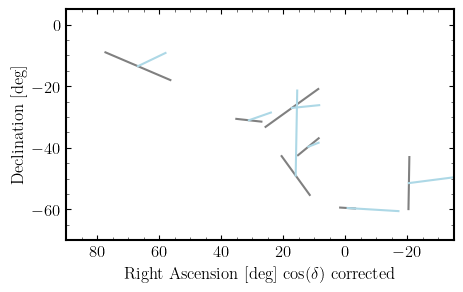

In [78]:
plt.figure(figsize=(5,3))

for p1, p2 in zip(start_radec, end_radec):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray')

for p1, p2 in zip(av_radec.value, av_radec.value + 10*pm_vec_radec.value):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'lightblue')

plt.ylim(-70,5)
plt.xlim(90, -35)

plt.xlabel(r'Right Ascension [deg] $\cos(\delta)$ corrected')
plt.ylabel('Declination [deg]')

Finding the misalignment angle between the stream track and proper motion vectors

In [79]:
track_dot_pm = np.einsum('ij,ij->i', track_vec_radec_norm.value, pm_vec_radec_norm.value) 
# track_dot_pm_err = np.linalg.norm(pm_vec_radec_norm_err / pm_vec_radec_norm, axis=1) #assuming pm error dominates

DES_pm_angles_rad = np.arccos(track_dot_pm) * u.rad
DES_pm_angles_deg = DES_pm_angles_rad.to(u.deg)
DES_pm_angles_deg = np.where(DES_pm_angles_deg > 90*u.deg, 180*u.deg - DES_pm_angles_deg, DES_pm_angles_deg)

df['pm_angle'] = list(np.round(DES_pm_angles_deg.value,2))

In [80]:
track_dot_pm_err = ( (track_vec_radec_norm_err/track_vec_radec_norm).value**2 
                    + (pm_vec_radec_norm_err/pm_vec_radec_norm).value**2 )**0.5
track_dot_pm_err = np.linalg.norm(track_dot_pm_err, axis=1)

DES_pm_angles_deg_err = track_dot_pm_err * (1 / (1 - track_dot_pm**2)**0.5)

In [81]:
df['pm_angle_err'] = list(np.round(DES_pm_angles_deg_err,2))
df

,mu_alpha_cos_delta,mu_alpha_cos_delta_error,mu_delta,mu_delta_error,endpoints_start_radec,endpoints_end_radec,distance_kpc,pm_angle,pm_angle_err
Aliqa Uma,0.25,0.03,-0.71,0.05,"(31.7, -31.5)","(40.8, -30.6)",28.8,25.75,0.27
ATLAS,0.09,0.03,-0.88,0.03,"(9.3, -20.9)","(30.7, -33.2)",22.9,30.05,0.52
Chenab,0.32,0.03,-2.47,0.04,"(-40.7, -59.9)","(-28.3, -43.0)",39.8,81.65,0.79
Elqui,0.13,0.04,-0.33,0.09,"(10.7, -36.9)","(20.6, -42.4)",50.1,18.07,0.29
Phoenix,2.76,0.02,-0.05,0.02,"(20.1, -55.3)","(27.9, -42.7)",19.1,36.76,5.09
Tucana III,-0.10,0.04,-1.64,0.04,"(-6.3, -59.7)","(3.2, -59.4)",25.1,0.08,760.77
Turranburra,0.43,0.04,-0.89,0.04,"(59.3, -18.0)","(78.3, -9.0)",27.5,49.05,0.13


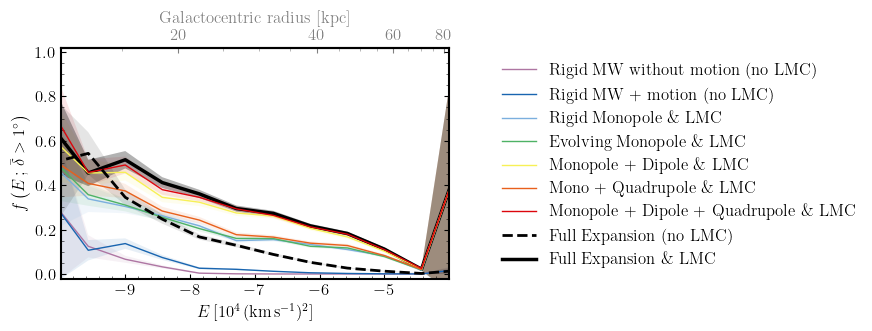

In [39]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/16384-dt1Myr/'
potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
               'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'full-MWhalo-full-MWdisc-full-LMC.hdf5'])
labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
       'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

frac_streams_indiv(path, 'deviation', potentials, labels, 'frac_streams_deviation', False)
